title: Spend Efficiency Curve using non-linear regression models
author: Yu-Huai Lin
date: 2023-03-22
region: EU
link: https://docs.google.com/presentation/d/1holNp5nxGLYTRuFTQfmnDCd96NF5tuG8Y_Te92mGinA/edit#slide=id.g204215641a2_0_0
tags: acquisition, signup, conversion, regression, linear, mmm, marketing, marketing-mix-modelling, python
summary: This analysis aims to quantify the relationships between monthly spend and sign-ups with non-linear (logarithmic) functions from scipy. 


# Efficiency Curve: Marketing Spend vs Sign-Ups 
## MMM and Last-click

### Overview

---

The efficiency curve indicates the correlation between monthly spend and sign-ups of each country. As the spend increases, the amount of sign-ups increases. However, the level of increase diminishes and the curve starts to flatten at one point. The point should more or less indicate the ideal spend level as the number of sign-ups increase will be saturated at this point.
The fitted curve line is a logarithmic relation of the 2 metrics. 

### Insights

---


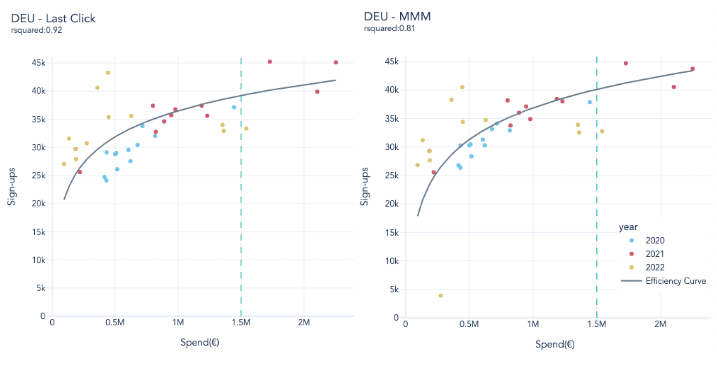



### Technical Details

---
This notebook utilize Scipy.Optmize library and use a log function to fit the efficiency curve


In [3]:
import psycopg2  # Connect to DWH
import os
import json
import numpy as np
import pandas as pd
import datetime as dt
import csv

In [26]:
from datetime import datetime, date

In [46]:
from scipy.optimize import curve_fit
from numpy import linspace, log, sin, pi
from matplotlib import pyplot as plt
from random import random
from datetime import datetime, date
import plotly.graph_objs as go
import plotly.express as px  # graphing

### Set up database connection

In [77]:
con_file = os.path.expanduser("~/Documents/creds.json")
with open(con_file, "r") as f:
    config = json.load(f)

# Get creds from locally stored file and connect to Redshift
rs_dwh = config["datawarehouses"]["rs_dwh"]

In [78]:
# connect to EU Redshift DWH
con_rs = psycopg2.connect(
    dbname=rs_dwh["db"],
    host=rs_dwh["host"],
    port=rs_dwh["port"],
    user=rs_dwh["user"],
    password=rs_dwh["password"],
)

con_rs
# con_rs.close()

<connection object at 0x7fb1289a49f0; dsn: 'user=yu_huai_lin_reader password=xxx dbname=n26 host=n26-dwh.cfxsmcyyfcch.eu-central-1.redshift.amazonaws.com port=5439', closed: 0>

### Query and Getting Data

In [79]:
query = """
WITH last_click_prep AS (
SELECT 
        date_trunc('month', date) as month
        ,country AS country
        , SUM(nullif(suc,0)) AS suc
        , SUM(nullif(cost_with_vat,0)) AS cost
    FROM 
        dbt.mktg_full_funnel_daily_spend
    WHERE 
    country IN ('DEU', 'AUT', 'ESP', 'FRA', 'ITA')
    and date >= '2020-01-01'
    and date <= '2022-12-31'
    GROUP BY 
        1,2
        )
        
, mmm_prep AS ( 
    SELECT 
        date_trunc('month', date) as month
        , country
        , SUM(nullif(attribution,0)) AS mmm_signups
    FROM 
       dbt.mktg_mmm_table
    WHERE 
 country IN ('DEU', 'AUT', 'ESP', 'FRA', 'ITA')
 and date >= '2020-01-01'
    and date <= '2022-12-31'
    GROUP BY 
        1,2
)

SELECT 
    lc.month
    , lc.country
    , SUM(suc) AS lc_signups
    , SUM(mmm_signups ) AS mmm_signups
    , SUM(lc.cost) AS cost
FROM 
    mmm_prep AS m
full outer join 
    last_click_prep  AS lc
ON 
    m.month= lc.month
    AND m.country = lc.country
GROUP BY 1,2
order by 1,2

"""

In [80]:
def df_from_sql(query, con=con_rs):
    """Return dataframe from sql query."""

    df = pd.read_sql(sql=query, con=con)

    return df

In [81]:
df = df_from_sql(query, con=con_rs)

In [449]:
df.head()

,month,country,lc_signups,mmm_signups,cost
0,2020-01,AUT,4615.0,4619.7989,9.789756e+04
1,2020-01,DEU,37135.0,37872.5830,1.444727e+06
2,2020-01,ESP,19366.0,21507.2939,2.870482e+05
3,2020-01,FRA,73598.0,70489.5204,1.503067e+06
4,2020-01,ITA,27640.0,27855.4563,3.434093e+05


In [544]:
df["month"] = pd.to_datetime(df["month"]).dt.strftime("%Y-%m")
df["year"] = pd.to_datetime(df["month"]).dt.strftime("%Y")

In [551]:
de = df[df["country"] == "DEU"]

## Efficiency Curve

In [448]:
def func(x, a, b, c):
    # return a * np.exp(-b * x) + c
    return a * np.log(b * x) + c

In [ ]:
def calculate_r_squared(x, y):
    residuals = y - func(x, *popt)
    ss_res = np.sum(residuals**2)  #  residulas sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)  # total sum of squares
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [548]:
def plot_efficiency_curve(df, country, col):
    if col == "lc_signups":
        text = "Last Click"
    else:
        text = "MMM"

    data = df[df["country"] == country]
    x = np.array(data["cost"])
    y = np.array(data[col])

    x.sort()
    y.sort()

    popt, pcov = curve_fit(func, x, y)
    y_fit = np.array(func(x, *popt))

    r_2 = calculate_r_squared(x, y)

    fig = px.scatter(
        data,
        x="cost",
        y=col,
        title=f"{country} - {text} <br><sup>rsquared:{round(r_2,2)} </sup>",
        height=550,
        width=500,
        template="plotly_white",
        color="year",
        color_discrete_sequence=["darkblue"],
    )
    fig.update_layout(
        xaxis_title="Spend(€)",
        yaxis_title="Sign-ups",
        font=dict(
            family="Avenir",
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=x,
            y=func(x, *popt),
            mode="lines",
            name="Efficiency Curve",
            marker=dict(color="lightslategrey", size=5),
        )
    )
    fig.update(layout_showlegend=False)

    fig.show()

In [549]:
for c in ["lc_signups", "mmm_signups"]:
    plot_efficiency_curve(df, "DEU", c)

In [521]:
for country in ["FRA", "ESP", "AUT", "ITA"]:
    for c in ["lc_signups", "mmm_signups"]:
        plot_efficiency_curve(df, country, c)

ValueError: array must not contain infs or NaNs

## Deep Dive Analysis

In [565]:
def plot_one_efficiency_curve(df, country, col):
    if col == "lc_signups":
        text = "Last Click"
    else:
        text = "MMM"

    data = df[df["country"] == country]
    x = np.array(data["cost"])
    y = np.array(data[col])

    x.sort()
    y.sort()

    popt, pcov = curve_fit(func, x, y)
    y_fit = np.array(func(x, *popt))

    r_2 = calculate_r_squared(x, y)

    fig = px.scatter(
        data,
        x="cost",
        y=col,
        title=f"{country} - {text} <br><sup>rsquared:{round(r_2,2)} </sup>",
        height=550,
        width=600,
        template="plotly_white",
        color="year"
        # color_discrete_sequence=['darkblue']
        ,
        color_discrete_sequence=px.colors.qualitative.Safe,
    )
    fig.update_layout(
        xaxis_title="Spend(€)",
        yaxis_title="Sign-ups",
        font=dict(
            family="Avenir",
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=x,
            y=func(x, *popt),
            mode="lines",
            name="Efficiency Curve",
            marker=dict(color="lightslategrey", size=5),
        )
    )
    # fig.update(layout_showlegend=False)

    return fig

In [584]:
deu = plot_one_efficiency_curve(df, "DEU", "lc_signups")

# deu.add_hline(y=45203, line_width=1, line_dash="dash", line_color="lightseagreen")
deu.add_vline(x=1500000, line_width=1, line_dash="dash", line_color="lightseagreen")
deu.update_yaxes(range=[0, 46000])
deu.update(layout_showlegend=False)
# deu.update_layout(legend=dict(
#     yanchor="bottom",
#     y=0.1,
#     xanchor="left",
#     x=0.7
# ))

In [ ]:
 = plot_one_efficiency_curve(df, 'DEU', 'mmm_signups')

#deu.add_hline(y=45203, line_width=1, line_dash="dash", line_color="lightseagreen")
deu.add_vline(x=1500000, line_width=1, line_dash="dash", line_color="lightseagreen")
deu.update_yaxes(range=[0, 46000])

In [453]:
x = np.array(de["cost"])
y = np.array(de["lc_signups"])

In [454]:
x.sort()
y.sort()
print(x)

[  93641.415       134119.17195     185382.203255    186707.889
  188968.96115     220540.63855     274586.40848156  358981.80131409
  415059.6537592   429809.93969709  431637.41418308  444352.35309655
  448390.183234    499720.0235888   509000.80090528  516349.40279866
  605377.68699857  621235.63024884  627885.69611159  678004.54677372
  716843.34635678  799902.01405168  817087.06747008  822688.934847
  889546.27752682  945604.41453137  977689.33032472 1186703.38539663
 1230574.35470748 1352474.02114589 1361895.48667295 1444727.11443966
 1541355.21216    1727895.38570472 2104638.76246932 2252278.60453857]


In [455]:
print(y)

[24126. 24737. 25599. 26107. 27043. 27543. 27901. 28788. 28991. 29113.
 29539. 29707. 29716. 30444. 30715. 31560. 32033. 32760. 32922. 33336.
 33813. 33977. 34602. 35374. 35574. 35603. 35702. 36747. 37135. 37386.
 37396. 39887. 40601. 43266. 45096. 45203.]


In [458]:
popt, pcov = curve_fit(func, x, y)

print(popt)
y_fit = np.array(func(x, *popt))

[ 6.67905937e+03  3.24526128e-03 -1.75052043e+04]


In [459]:
print(y_fit)

[20676.76476462 23076.25687765 25238.20768158 25285.800302
 25366.19928041 26398.10864219 27862.05170244 29652.07767113
 30621.54687492 30854.78534785 30883.12330453 31077.0292149
 31137.44773427 31861.35217854 31984.25756591 32079.99576059
 33142.4261587  33315.13265789 33386.24921543 33899.17330185
 34271.21920205 35003.45721005 35145.43010909 35191.06481809
 35712.92222114 36121.09812659 36343.96261708 37637.98038399
 37880.44237477 38511.30964196 38557.67531187 38952.02692068
 39384.43978884 40147.46949392 41464.84526209 41917.67596143]


In [557]:
fig = px.scatter(
    de,
    x="cost",
    y="lc_signups",
    color="year",
    title="DEU",
    height=600,
    width=800,
    template="plotly_white",
    color_discrete_sequence=px.colors.qualitative.Safe,
)
fig.update_layout(
    xaxis_title="Spend(€)",
    yaxis_title="Sign-ups",
    font=dict(
        family="Avenir",
    ),
)
fig.add_trace(
    go.Scatter(
        x=x,
        y=func(x, *popt),
        mode="lines",
        name="Efficiency Curve",
        marker=dict(color="lightslategrey", size=5),
    )
)
fig.add_hline(y=45203, line_width=1, line_dash="dash", line_color="lightseagreen")
fig.add_vline(x=1727895, line_width=1, line_dash="dash", line_color="lightseagreen")

fig.add_hline(y=45203, line_width=1, line_dash="dash", line_color="lightseagreen")
fig.add_vline(x=1727895, line_width=1, line_dash="dash", line_color="lightseagreen")

fig